In [1]:
#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as mpyplot
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [10]:
#%% Define file locations
WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_34/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_32/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_30/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_28/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_26/"  

# Choose which domain to evaluate
domain = 'd05'

# Whether or not to save figures
saveFig = 'False'

# Maximum height to save the data
max_z_save = 50 #300

dirFig = "/pl/active/JKL_IDEAL/hurricanes/Figures/animation/"



In [3]:
#%% Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4

In [4]:
# Time series output for each restart
label = ''
if 'sst_26' in WRF_DIRECTORY:
    label = '26 C'
elif 'sst_28' in WRF_DIRECTORY:
    label = '28 C'
elif 'sst_30' in WRF_DIRECTORY:
    label = '30 C'
elif 'sst_32' in WRF_DIRECTORY:
    label = '32 C'
elif 'sst_34' in WRF_DIRECTORY:
    label = '34 C'

In [5]:
#%% Extract data from 3D fields
# Find auxHist files for current domain within directory
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    if domain in entries[i]:
        if 'auxH' in entries[i]:
            ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)

# Extract and save data from each auxHist file
for i_f in np.arange(0,len(ofInterest),1):
    # Open file
    ds = xr.open_dataset(WRF_DIRECTORY+str(entries[ofInterest[i_f]]),decode_times=False)
    # Extract data
    u_temp = np.array(ds['U'])
    v_temp = np.array(ds['V'])
    w_temp = np.array(ds['W'])
    time_temp = np.array(ds['Times'])
    # De-stagger variables
    u_temp = 0.5*(u_temp[:,:,:,0:np.shape(u_temp)[3]-1]+u_temp[:,:,:,1:np.shape(u_temp)[3]])
    v_temp = 0.5*(v_temp[:,:,0:np.shape(v_temp)[2]-1,:]+v_temp[:,:,1:np.shape(v_temp)[2],:])
    w_temp = 0.5*(w_temp[:,0:np.shape(w_temp)[1]-1,:,:]+w_temp[:,1:np.shape(w_temp)[1],:,:])
    uv_temp = (u_temp**2 + v_temp**2)**0.5
    # Save variables
    if i_f==0:
        # Height variables
        ph = ds['PH']
        ph = np.array(ph[0,:,:,:])
        ph = np.mean(np.mean(ph,axis=1),axis=1)
        phb = ds['PHB']
        phb = np.array(phb[0,:,:,:])
        phb = np.mean(np.mean(phb,axis=1),axis=1)
        height_stag = (ph+phb)/9.81
        height_agl = 0.5*(height_stag[1:] + height_stag[0:-1])
        # Only keep data within heights of interest
        iz_max = np.argmin(np.abs(height_agl - max_z_save))
        u_temp = u_temp[:,0:iz_max,:,:]
        v_temp = v_temp[:,0:iz_max,:,:]
        w_temp = w_temp[:,0:iz_max,:,:]
        uv_temp = uv_temp[:,0:iz_max,:,:]
        height_agl = height_agl[0:iz_max]
        # Create new variables
        u = np.zeros_like(u_temp) + u_temp
        v = np.zeros_like(v_temp) + v_temp
        w = np.zeros_like(w_temp) + w_temp
        uv = np.zeros_like(uv_temp) + uv_temp
        Time = []
        Time.append(time_temp)
        # Domain dimensions
        dx = ds.DX
        n_x = dx*np.arange(0,np.shape(uv)[3])
        n_y = dx*np.arange(0,np.shape(uv)[2])
        # Free-up memory
        ph = 0.0
        phb = 0.0
        height_stag = 0.0
    else:
        # Only keep data within heights of interest
        u_temp = u_temp[:,0:iz_max,:,:]
        v_temp = v_temp[:,0:iz_max,:,:]
        w_temp = w_temp[:,0:iz_max,:,:]
        uv_temp = uv_temp[:,0:iz_max,:,:]
        # Append data to saved variables
        u = np.append(u,u_temp,axis=0)
        v = np.append(v,v_temp,axis=0)
        w = np.append(w,w_temp,axis=0)
        uv = np.append(uv,uv_temp,axis=0)
        Time.append(time_temp)
    # Free-up memory
    u_temp = 0.0
    v_temp = 0.0
    w_temp = 0.0
    uv_temp = 0.0
    # Close file
    ds.close()
    print('Done with %i out of %i' % (i_f,len(ofInterest)-1))
    

Done with 0 out of 25
Done with 1 out of 25
Done with 2 out of 25
Done with 3 out of 25
Done with 4 out of 25
Done with 5 out of 25
Done with 6 out of 25
Done with 7 out of 25
Done with 8 out of 25
Done with 9 out of 25
Done with 10 out of 25
Done with 11 out of 25
Done with 12 out of 25
Done with 13 out of 25
Done with 14 out of 25
Done with 15 out of 25
Done with 16 out of 25
Done with 17 out of 25
Done with 18 out of 25
Done with 19 out of 25
Done with 20 out of 25
Done with 21 out of 25
Done with 22 out of 25
Done with 23 out of 25
Done with 24 out of 25
Done with 25 out of 25


In [6]:
#%% Create time vector (after initialization) (ignore dates)
# Create large datetime64 array
ttime = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time)[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time)[0]):
    a = str(Time[i_t])
    ttime[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime = ttime[0:np.shape(Time)[0]]


In [7]:
#%% Sort 3D fields by time
i_sort = np.argsort(ttime)
ttime = ttime[i_sort]
u = u[i_sort,:,:,:]
v = v[i_sort,:,:,:]
w = w[i_sort,:,:,:]
uv = uv[i_sort,:,:,:]


In [8]:
#%% Discard first 5-min of simulation
t0 = ttime[0] + np.timedelta64(5,'m')
print(ttime)
u = u[ttime>t0,:,:,:]
v = v[ttime>t0,:,:,:]
w = w[ttime>t0,:,:,:]
uv = uv[ttime>t0,:,:,:]
ttime = ttime[ttime>t0]
print(ttime)

['2000-01-07T20:01:00' '2000-01-07T20:03:00' '2000-01-07T20:05:00'
 '2000-01-07T20:07:00' '2000-01-07T20:09:00' '2000-01-07T20:11:00'
 '2000-01-07T20:13:00' '2000-01-07T20:15:00' '2000-01-07T20:17:00'
 '2000-01-07T20:19:00' '2000-01-07T20:21:00' '2000-01-07T20:23:00'
 '2000-01-07T20:25:00' '2000-01-07T20:27:00' '2000-01-07T20:29:00'
 '2000-01-07T20:31:00' '2000-01-07T20:33:00' '2000-01-07T20:35:00'
 '2000-01-07T20:37:00' '2000-01-07T20:39:00' '2000-01-07T20:41:00'
 '2000-01-07T20:43:00' '2000-01-07T20:45:00' '2000-01-07T20:47:00'
 '2000-01-07T20:49:00' '2000-01-07T20:51:00']
['2000-01-07T20:07:00' '2000-01-07T20:09:00' '2000-01-07T20:11:00'
 '2000-01-07T20:13:00' '2000-01-07T20:15:00' '2000-01-07T20:17:00'
 '2000-01-07T20:19:00' '2000-01-07T20:21:00' '2000-01-07T20:23:00'
 '2000-01-07T20:25:00' '2000-01-07T20:27:00' '2000-01-07T20:29:00'
 '2000-01-07T20:31:00' '2000-01-07T20:33:00' '2000-01-07T20:35:00'
 '2000-01-07T20:37:00' '2000-01-07T20:39:00' '2000-01-07T20:41:00'
 '2000-01-07T20:

In [25]:
time_since = ttime - ttime[0] + np.timedelta64(5,'m')
time_since = time_since.astype('timedelta64[m]')
print(time_since)

[ 5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49]


In [27]:
#%% Make GIF using initial x-y grid
for it in np.arange(len(ttime)):
    mpyplot.pcolormesh(n_x/1000,n_y/1000,uv[it,0,:,:],vmin=0,vmax=55) 
    mpyplot.title('t = '+str(time_since[it]),fontsize=18)
    cbar = mpyplot.colorbar(extend='max')
    cbar.set_label(r'U [m s$^{-1}$]',fontsize=14)
    mpyplot.xlabel('x [km]',fontsize=14)
    mpyplot.ylabel('y [km]',fontsize=14)
    mpyplot.savefig(dirFig + "U_init_xy_" + str(it) + ".png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
    mpyplot.close()
stop

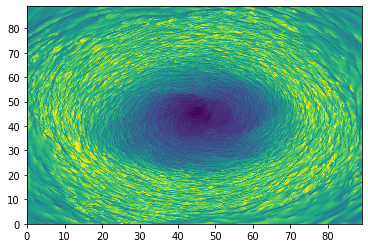

In [30]:
mpyplot.pcolormesh(n_x/1000,n_y/1000,uv[it,-1,:,:],vmin=0,vmax=65) 

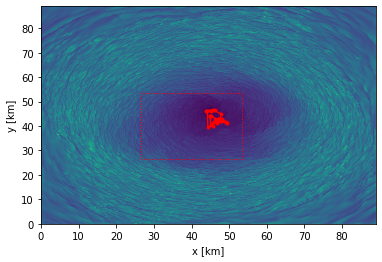

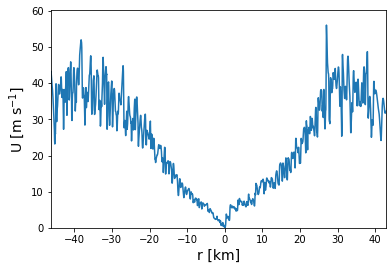

NameError: name 'stop' is not defined

In [9]:
#%% Find hurricane center for each time
# Choose height at which the center of the hurricane is going to be defined
iz_c = 0

# Initialize array
center = np.zeros([len(ttime),2]) + np.nan # [x,y]

X_grid,Y_grid = np.meshgrid(n_x,n_y)
X_grid = X_grid.flatten()
Y_grid = Y_grid.flatten()

for iitt in np.arange(np.shape(uv)[0]):
    # Ignore boundaries of domain
    temp_uv = np.zeros(np.shape(uv[iitt,iz_c,:,:])) + uv[iitt,iz_c,:,:]
    temp_uv[0:10,:] = np.nan
    temp_uv[-10:,:] = np.nan
    temp_uv[:,0:10] = np.nan
    temp_uv[:,-10:] = np.nan
    uv_flat = temp_uv.flatten() 
    uv_flat[np.isnan(uv_flat)] = 0
    max_ws_ref = np.argmax(uv_flat)
    # Limits of area where to look for hurricane center
    lim_low_x = 0.3*np.max(n_x)
    lim_low_y = 0.3*np.max(n_y)
    lim_high_x = 0.6*np.max(n_x)
    lim_high_y = 0.6*np.max(n_x)
    # Create small meshgrid
    small_x,small_y = np.meshgrid(n_x[(n_x<lim_high_x)&(n_x>lim_low_x)],n_y[(n_y<lim_high_y)&(n_y>lim_low_y)])
    flat_smallX = small_x.flatten()
    flat_smallY = small_y.flatten()

    # Crop array
    temp_uv_1 = uv[iitt,0,(n_y<lim_high_y)&(n_y>lim_low_y),:]
    temp_uv_2 = temp_uv_1[:,(n_x<lim_high_x)&(n_x>lim_low_x)]
    # Flatten array
    temp_uv_flat = temp_uv_2.flatten()
    # Find location of minimum
    if np.any(temp_uv_flat)==True:
        i_min = np.argmin(temp_uv_flat)
        # Save location of minimum
        center[iitt,0] = flat_smallX[i_min]
        center[iitt,1] = flat_smallY[i_min]
    else:
        # Save location of minimum
        center[iitt,0] = np.mean(n_x)
        center[iitt,1] = np.mean(n_y)
# Free-up memory
X_grid = 0.0
Y_grid = 0.0
temp_uv = 0.0
uv_flat = 0.0
max_ws_ref = 0.0
small_x = 0.0
small_y = 0.0
flat_smallX = 0.0
flat_smallY = 0.0
temp_uv_1 = 0.0
temp_uv_2 = 0.0
temp_uv_flat = 0.0

# Show area considered for center of hurricane
mpyplot.figure()
mpyplot.pcolormesh(n_x/1000,n_y/1000,uv[-1,iz_c,:,:]) 
mpyplot.plot(center[:,0]/1000,center[:,1]/1000,'o-',color='red',markersize=3)
mpyplot.fill(np.array([lim_low_x,lim_high_x,lim_high_x,lim_low_x])/1000,np.array([lim_low_y,lim_low_y,lim_high_y,lim_high_y])/1000,facecolor='none',edgecolor='r',linestyle=':',label='Area')
mpyplot.xlabel('x [km]')
mpyplot.ylabel('y [km]')
# mpyplot.xlim((min(center[:,0]) - 50*dx)/1000,(max(center[:,0]) + 50*dx)/1000)
# mpyplot.ylim((min(center[:,1]) - 50*dx)/1000,(max(center[:,1]) + 50*dx)/1000)
mpyplot.show()
mpyplot.close()  


# Radial distribution of wind speed
mpyplot.figure()
r_x = (n_x - center[-1,0])/1000
mpyplot.plot(r_x,uv[-1,0,int(center[-1,1]/dx),:])
mpyplot.xlim(np.min((n_x - center[-1,0])/1000),np.max((n_x - center[-1,0])/1000))
mpyplot.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
mpyplot.ylim(0,np.max(uv[:,iz_c,int(center[-1,1]/dx),:]))
mpyplot.xlabel('r [km]',fontsize=14)
mpyplot.ylabel('U [m s$^{-1}$]',fontsize=14)
mpyplot.show()
mpyplot.close()  

stop

In [ ]:
#%% Crop all 3D fields to a shared reference frame that is centered on the center of the hurricane
# Find the maximum radial distance from the hurricane's center that is shared for all times
max_dist_fromCent = 100000
for it in np.arange(len(ttime)):
    # Distance from hurricane cetner to domain boundaries
    dd_x = np.min([center[it,0] - n_x[0],n_x[-1] - center[it,0]])
    dd_y = np.min([center[it,1] - n_y[0],n_y[-1] - center[it,1]])
    # Minimum distance to domain boundaries
    dd = np.min([dd_x,dd_y])
    if dd<max_dist_fromCent:
        max_dist_fromCent = dd
# Round down
temp = np.floor(max_dist_fromCent/1000)
max_dist_fromCent = temp*1000

# Initialize array
u_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
v_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
w_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
uv_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan

for iitt in np.arange(len(ttime)):
    # Geometrical center
    geo_cent = [center[iitt,0],center[iitt,1]]
    ix_c = int(geo_cent[0]/dx)
    iy_c = int(geo_cent[1]/dx)
    # Save portion of hurricane
    u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    
# Release memory
u = 0.0
v = 0.0
w = 0.0
uv = 0.0

# Temporal average of centered velocity fields
mean_u_r = np.nanmean(u_r,axis=0)
mean_v_r = np.nanmean(v_r,axis=0)
mean_w_r = np.nanmean(w_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)


# New distance arrays
n_x_r = np.arange(np.shape(mean_uv_r)[2])*dx
n_y_r = np.arange(np.shape(mean_uv_r)[1])*dx
n_x_r = n_x_r - np.mean(n_x_r)
n_y_r = n_y_r - np.mean(n_y_r)


In [ ]:
#%% Figures showing time-averaged velocity fields for centered hurricane

# Velocity contours at one height
iz = 0
mpyplot.figure()
im1 = mpyplot.contourf(n_x_r/1000,n_y_r/1000,mean_uv_r[iz,:,:],levels=15) 
mpyplot.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
mpyplot.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = mpyplot.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
# mpyplot.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  

# Radial distribution of winds at one height
mpyplot.figure()
mpyplot.plot(n_x_r/1000,mean_uv_r[iz,int(0.5*len(n_y_r)),:],label='west-east slice')
mpyplot.plot(n_y_r/1000,mean_uv_r[iz,:,int(0.5*len(n_x_r))],label='south-north slice')
mpyplot.xlim(-30,30)
mpyplot.ylim(0,np.max(mean_uv_r[iz,:,:]))
mpyplot.xlabel('r [km]',fontsize=14)
mpyplot.ylabel('$\overline{U}$ [m s$^{-1}$',fontsize=14)
mpyplot.legend()
# mpyplot.savefig(WRF_DIRECTORY + "r_hurr.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  

# Slice of velocity field
mpyplot.figure()
im1 = mpyplot.contourf(n_x_r/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:],levels=15) 
mpyplot.xlabel('x [km]',fontsize=14)
mpyplot.ylabel('Height [m]',fontsize=14)
mpyplot.xlim(0,n_x_r[-1]/1000)
cbar = mpyplot.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
# mpyplot.savefig(WRF_DIRECTORY + "time_avg_U.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()
mpyplot.close()  


print(np.max(mean_uv_r[0,int(0.5*len(n_y_r)),int(0.5*len(n_x_r)):]))
print(np.max(mean_uv_r[0,int(0.5*len(n_y_r)),0:int(0.5*len(n_x_r))]))

In [ ]:
#%% Calculate mean wind direction in domain
wDir = np.arctan2(mean_v_r,mean_u_r)*180/np.pi

# Wind direction in engineering coordinates (from [1,0] vector )
wDir[wDir<0] = (180 + wDir[wDir<0]) + 180


In [ ]:
#%% Fit double-Gaussian and 4-th order polynomial to radial velocity distribution and find hurricane eyewall
from scipy.optimize import curve_fit

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0)**2 / (2*(sigma**2)))

def x4(x, a,b,c,d,e):
    return a*(x**4) + b*(x**3) + c*(x**2) + d*x + e

# Hurricane eyewall
r_eye = np.zeros(len(ttime))
use_fit = '4th poly' # 'gauss'


mpyplot.figure()
col = mpyplot.cm.viridis(np.linspace(0,1,len(ttime)))
for iitt in np.arange(len(ttime)):
    ## 4-th order polynomial
    if use_fit=='4th poly':
        # Fit east-west side
        popt_ew_4, pcov_ew_4 = curve_fit(x4, n_x_r/1000,uv_r[iitt,iz,int(0.5*len(n_y_r)),:])
        # Fit north-south side
        popt_ns_4, pcov_ns_4 = curve_fit(x4, n_y_r/1000,uv_r[iitt,iz,:,int(0.5*len(n_x_r))])
        fit = x4(n_x_r/1000, *popt_ew_4)
    ## Gaussian
    elif use_fit=='gauss':
        # Fit east-west side
        popt_ew_g, pcov_ew_g = curve_fit(gauss, n_x_r/1000,uv_r[iitt,iz,int(0.5*len(n_y_r)),:])
        # Fit north-south side
        popt_ns_g, pcov_ns_g = curve_fit(gauss, n_y_r/1000,uv_r[iitt,iz,:,int(0.5*len(n_x_r))])
        fit = gauss(n_x_r/1000, *popt_ew_g)
    # Hurricane eyewall
    temp_re = np.abs(n_y_r[np.argmax(fit[0:int(0.5*len(n_x_r))])])
    temp_re2 = np.abs(n_y_r[np.argmax(uv_r[iitt,iz,:,int(0.5*len(n_x_r))])])
    r_eye[iitt] = temp_re
    if np.abs(temp_re - temp_re2)>3000:
        r_eye[iitt] = temp_re2
    # Plot fit
    mpyplot.plot(n_x_r/1000, fit,color=col[iitt],linestyle='-')
# Mean wind speed
mpyplot.plot(n_x_r/1000,mean_uv_r[iz,int(0.5*len(n_y_r)),:],'-k')
# Mean eyewall radius
r_eye_mean = np.median(r_eye)
mpyplot.plot([-r_eye_mean/1000,-r_eye_mean/1000],[0,1.02*np.max(mean_uv_r[0,:,:])],linestyle='--',color='lightgrey')
mpyplot.plot([r_eye_mean/1000,r_eye_mean/1000],[0,1.02*np.max(mean_uv_r[0,:,:])],linestyle='--',color='lightgrey')
mpyplot.xlim(n_x_r[0]/1000,n_x_r[-1]/1000)
mpyplot.ylim(0,1.02*np.max(mean_uv_r[0,:,:]))
mpyplot.xlabel('r [km]',fontsize=15)
mpyplot.ylabel('U [m s$^{-1}$]',fontsize=15)
mpyplot.show()
mpyplot.close()

print('Mean hurricane eyewall is at %f km' % (r_eye_mean/1000))

In [ ]:
if 'sst_28' in WRF_DIRECTORY:
    r_eye_mean = 21300 
print(r_eye_mean)

In [ ]:
# Average radial distribution of winds
rad_ws_avg = np.zeros([4,int(0.5*len(n_y_r))])
rad_ws_avg[0,:] = np.flip(mean_uv_r[iz,int(0.5*len(n_y_r)),:int(0.5*len(n_y_r))])
rad_ws_avg[1,:] = mean_uv_r[iz,int(0.5*len(n_y_r)),int(0.5*len(n_y_r)):-1]
rad_ws_avg[2,:] = mean_uv_r[iz,int(0.5*len(n_y_r)):-1,int(0.5*len(n_y_r))]
rad_ws_avg[3,:] = np.flip(mean_uv_r[iz,0:int(0.5*len(n_y_r)),int(0.5*len(n_y_r))])
mpyplot.figure(figsize=(5,5))
mpyplot.title(label)
for ii in np.arange(np.shape(rad_ws_avg)[0]):
    mpyplot.plot(n_x_r[int(0.5*len(n_y_r)):-1]/r_eye_mean,rad_ws_avg[ii,:])
mpyplot.plot(n_x_r[int(0.5*len(n_y_r)):-1]/r_eye_mean,np.mean(rad_ws_avg,axis=0),'-k')
mpyplot.plot([1,1],[0,1.1*np.max(rad_ws_avg)],'-k',linewidth=0.5)
mpyplot.ylim(0,1.1*np.max(rad_ws_avg))
mpyplot.xlim(0,np.max(n_x_r[int(0.5*len(n_y_r)):-1]/r_eye_mean))
mpyplot.ylabel(r'$\overline{U}$ [m s$^{-1}$]',fontsize=14)
mpyplot.xlabel(r'$\hat{r}$ [-]',fontsize=14)


In [ ]:
#%% Save radial distribution of mean winds
saveRadWS = 'True'
if saveRadWS == 'True':
    ws_distr = np.mean(rad_ws_avg,axis=0)
    r_distr = n_x_r[int(0.5*len(n_y_r)):-1]/r_eye_mean
    fName = 'radWS.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(r_distr)):
            strr = str(r_distr[i]) + ',' + str(ws_distr[i]) # r,U
            f.write(strr)
            f.write('\n')

In [ ]:
print(1.2*r_eye_mean)
print(n_x_r[-1]/r_eye_mean)

In [ ]:
#%% Mean wind speed profile at multiple radial locations
r_r = np.arange(0.8,1.3,0.1)
r_r = r_r[r_r*r_eye_mean<n_x_r[-1]]

if 'sst_34' in WRF_DIRECTORY:
    r_r = [0.8,0.9,1,1.1,1.15]

col = mpyplot.cm.cividis(np.linspace(0,1,len(r_r)))
# col = mpyplot.cm.Spectral(np.linspace(0,1,len(r_r)))

# Wind speed profiles
mpyplot.figure(figsize=(14,4))
# u-wind speed
mpyplot.subplot(1,4,1)
for ir in np.arange(len(r_r)):
    ii = np.argmin(np.abs(r_r[ir]*r_eye_mean + n_x_r))
    mpyplot.plot(mean_u_r[:,int(0.5*len(n_y_r)),ii],height_agl,color=col[ir],label=r'$\hat{r} = $'+str(r_r[ir]))
mpyplot.ylim(0,height_agl[-1])
mpyplot.ylabel('Height [m]',fontsize=14)
mpyplot.xlabel(r'$\overline{u}$ [m s$^{-1}$]',fontsize=14)

# v-wind speed
mpyplot.subplot(1,4,2)
for ir in np.arange(len(r_r)):
    ii = np.argmin(np.abs(r_r[ir]*r_eye_mean + n_x_r))
    mpyplot.plot(mean_v_r[:,int(0.5*len(n_y_r)),ii],height_agl,color=col[ir],label=r'$\hat{r} = $'+str(r_r[ir]))
mpyplot.ylim(0,height_agl[-1])
mpyplot.xlabel(r'$\overline{v}$ [m s$^{-1}$]',fontsize=14)

# uv-wind speed
mpyplot.subplot(1,4,3)
for ir in np.arange(len(r_r)):
    ii = np.argmin(np.abs(r_r[ir]*r_eye_mean + n_x_r))
    mpyplot.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ii],height_agl,color=col[ir],label=r'$\hat{r} = $'+str(r_r[ir]))
#     if r_r[ir]==1:
#         mpyplot.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ii],height_agl,color='black')
mpyplot.legend(fontsize=12)
mpyplot.ylim(0,height_agl[-1])
mpyplot.xlabel(r'$\overline{U}$ [m s$^{-1}$]',fontsize=14)

# Wind direction deviation from hub height
mpyplot.subplot(1,4,4)
i_zz = np.argmin(np.abs(height_agl - z_hh))
minnn = 0
maxxx = 0
for ir in np.arange(len(r_r)):
    ii = np.argmin(np.abs(r_r[ir]*r_eye_mean + n_x_r))
    mpyplot.plot(wDir[:,int(0.5*len(n_y_r)),ii] - wDir[i_zz,int(0.5*len(n_y_r)),ii],height_agl,color=col[ir],label=r'$\hat{r} = $'+str(r_r[ir]))
    if np.min(wDir[:,int(0.5*len(n_y_r)),ii] - wDir[i_zz,int(0.5*len(n_y_r)),ii]) < minnn:
        minnn = np.min(wDir[:,int(0.5*len(n_y_r)),ii] - wDir[i_zz,int(0.5*len(n_y_r)),ii])
    if np.max(wDir[:,int(0.5*len(n_y_r)),ii] - wDir[i_zz,int(0.5*len(n_y_r)),ii]) > maxxx:
        maxxx = np.max(wDir[:,int(0.5*len(n_y_r)),ii] - wDir[i_zz,int(0.5*len(n_y_r)),ii])
minnn = 1.1*minnn
maxxx = 1.1*maxxx
mpyplot.plot([0,0],[0,height_agl[-1]],'-k',linewidth=0.5)
mpyplot.fill([minnn,maxxx,maxxx,minnn],[z_hh-0.5*D,z_hh-0.5*D,z_hh+0.5*D,z_hh+0.5*D],alpha=0.2,color='lightgrey')
mpyplot.xlim(minnn,maxxx)
mpyplot.ylim(0,height_agl[-1])
mpyplot.xlabel(r'$\overline{\phi} - \overline{\phi}_{hh}$ [deg]',fontsize=14)

In [ ]:
#%% Save wind speed profile at different radial locations
saveRadWS_prof = 'True'
if saveRadWS_prof == 'True':
    ws_distr = np.zeros(len(r_r))
    fName = 'radWS_prof.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for iz in np.arange(len(height_agl)):
            strr = str(height_agl[iz]) + ','
            for ir in np.arange(len(r_r)):
                ii = np.argmin(np.abs(r_r[ir]*r_eye_mean + n_x_r))
                ws_distr[ir] = mean_uv_r[iz,int(0.5*len(n_y_r)),ii]
                strr = strr + str(ws_distr[ir]) # r,U
                if ir<len(r_r)-1:
                    strr = strr + ','
            f.write(strr)
            f.write('\n')  
                 

In [ ]:
#%% Temporal evolution of velocity spectra at different radial locations

# Choose height for analysis
iz = np.argmin(np.abs(height_agl - z_hh)) # 0

# Window length for overlapping spectra
ddxx = 20000 # 40000 
    
# Initialize arrays
mean_uv_circ = np.zeros([len(r_r),len(ttime)])
std_uv_circ = np.zeros([len(r_r),len(ttime)])
P_uv = np.zeros([len(r_r),len(ttime),int(0.5*ddxx/dx)+1])
k_uv = np.zeros([len(r_r),len(ttime),int(0.5*ddxx/dx)+1])
Pf_uv = np.zeros([len(r_r),len(ttime),int(0.5*ddxx/dx)+1])
f_uv = np.zeros([len(r_r),len(ttime),int(0.5*ddxx/dx)+1])

# Get spectra evolution at each radial location
for ir in np.arange(len(r_r)):
    # Current radial location
    r_i = r_r[ir]*r_eye_mean
    
    # Find (x,y) locations for semicircle
    x_locs_R_half = np.arange(-r_i,r_i,0.5*dx)
    x_locs_R_half = x_locs_R_half[1:-2]
    y_locs_R_half_plus = (r_i**2 - (x_locs_R_half)**2)**0.5
    y_locs_R_half_neg = -1*(r_i**2 - (x_locs_R_half)**2)**0.5

    # Get (x,y) locations for full circle
    x_locs_R_full = np.concatenate([x_locs_R_half,np.flip(x_locs_R_half)])
    y_locs_R_full = np.concatenate([y_locs_R_half_plus,np.flip(y_locs_R_half_neg)])

    ## Extract velocity along hurricane radius
    # Initialize arrays
    dist_alongR_common = np.arange(0,2*np.pi*r_i,dx)
    # Get spectra for each time
    for iitt in np.arange(len(ttime)):
        # Initialize arrays
        uv_alongR = np.zeros(np.shape(x_locs_R_full))
        x_alongR = np.zeros(np.shape(x_locs_R_full))
        y_alongR = np.zeros(np.shape(x_locs_R_full))
        
        # Choose starting point
        i_x = np.argmin(np.abs(x_locs_R_full[0] - n_x_r))
        i_y = np.argmin(np.abs(y_locs_R_full[0] - n_y_r))
        uv_alongR[0] = uv_r[iitt,iz,i_y,i_x]
        x_alongR[0] = n_x_r[i_x]
        y_alongR[0] = n_y_r[i_y]

        # Extract velocity at each radial location
        i_along = 0
        for i_r in np.arange(1,len(x_locs_R_full)):
            i_x = np.argmin(np.abs(x_locs_R_full[i_r] - n_x_r))
            i_y = np.argmin(np.abs(y_locs_R_full[i_r] - n_y_r))

            if (x_alongR[i_along] != n_x_r[i_x]) or (y_alongR[i_along] != n_y_r[i_y]):
                i_along = i_along + 1
                uv_alongR[i_along] = uv_r[iitt,iz,i_y,i_x]
                x_alongR[i_along] = n_x_r[i_x]
                y_alongR[i_along] = n_y_r[i_y]

        # Remove non-zero elements from array
        x_alongR = x_alongR[uv_alongR>0]
        y_alongR = y_alongR[uv_alongR>0]
        uv_alongR = uv_alongR[uv_alongR>0]

        # Distance along circle
        dist_alongR = np.zeros(len(x_alongR))
        for i in np.arange(1,len(dist_alongR)):
            dist_alongR[i] = dist_alongR[i-1] + ((x_alongR[i] - x_alongR[i-1])**2 + (y_alongR[i] - y_alongR[i-1])**2)**0.5

        # Interpolate array to common grid
        uv_alongR_common = np.interp(dist_alongR_common,dist_alongR,uv_alongR)
        
        ## Calculate statistics
        dx_alongR = np.mean(dist_alongR_common[1:] - dist_alongR_common[0:-1])
        n_ddxx = int(ddxx/dx_alongR)
        # Perturbation quantity
        pertUV_alongR = uv_alongR_common - np.nanmean(uv_alongR_common)
        # Detrend
        pertUV_alongR = scipy.signal.detrend(pertUV_alongR)
        # Get turbuelence spectra (wavenumber)
        k,P = signal.welch(pertUV_alongR, fs=1/dx_alongR,window='hanning',nperseg=n_ddxx,scaling='density')
        # Get turbuelence spectra (frequency)
        f,Pf = signal.welch(pertUV_alongR, fs=np.nanmean(uv_alongR_common)/dx_alongR,window='hanning',nperseg=n_ddxx,scaling='density')
        # Save spectra
        P_uv[ir,iitt,0:len(P)] = P
        k_uv[ir,iitt,0:len(P)] = k
        Pf_uv[ir,iitt,0:len(P)] = Pf
        f_uv[ir,iitt,0:len(P)] = f
        # Save mean and standard deviation of wind speed at radius
        mean_uv_circ[ir,iitt] = np.nanmean(uv_alongR_common)
        std_uv_circ[ir,iitt] = np.nanstd(uv_alongR_common)
        

        

In [ ]:
#%% Evaluate turbulence spectra evolution over time and radial location (wavenumber space)

# Temporal evolution of spectra at each radial location
col = mpyplot.cm.summer(np.linspace(0,1,len(ttime)))
mpyplot.figure(figsize=(13,4))
for ir in np.arange(len(r_r)):
    mpyplot.subplot(1,len(r_r),ir+1)
    mpyplot.title(r'$\hat{r}$ = '+str(r_r[ir]))
    for iitt in np.arange(len(ttime)):
        mpyplot.loglog(k_uv[ir,iitt,:],P_uv[ir,iitt,:],color=col[iitt])
    mpyplot.loglog(np.mean(k_uv[ir,:,:],axis=0),np.mean(P_uv[ir,:,:],axis=0),'-k')
    mpyplot.xlim(k_uv[ir,iitt,1],k_uv[ir,iitt,-1])
    mpyplot.xlabel(r'$k$ [m$^{-1}$]',fontsize=14)
    if ir==0:
        mpyplot.ylabel(r'E$_U$ [m$^3$ s$^{-2}$]',fontsize=14)
mpyplot.tight_layout()
mpyplot.show()
mpyplot.close()

# Spatial evolution of spectra for different radial locations (normalized)
col = mpyplot.cm.viridis(np.linspace(0,1,len(r_r)))
mpyplot.figure(figsize=(4,4))
for ir in np.arange(len(r_r)):
    normP = np.mean(P_uv[ir,:,:],axis=0)*np.mean(k_uv[ir,:,:],axis=0)/(np.mean(std_uv_circ[ir,:])**2)
    mpyplot.loglog(np.mean(k_uv[ir,:,:],axis=0),normP,color=col[ir],label=r'$\hat{r}$ = '+str(r_r[ir]))
#     mpyplot.loglog(k_uv[ir,0,:],S_k[ir,:],color=col[ir],linestyle='--')
mpyplot.loglog([1/(7*dx),1/(7*dx)],[10**-3,10**0],'--',color='lightgrey')
mpyplot.legend(fontsize=12)
mpyplot.xlim(k_uv[ir,iitt,1],k_uv[ir,iitt,-1])
mpyplot.xlabel(r'$k$ [m$^{-1}$]',fontsize=14)
mpyplot.ylabel(r'$k E_U/\sigma^2$ [-]',fontsize=14)
# mpyplot.ylabel(r'E$_U$ [m$^3$ s$^{-2}$]',fontsize=14)
mpyplot.tight_layout()
mpyplot.show()
mpyplot.close()

# Spatial evolution of spectra for different radial locations (absolute)
col = mpyplot.cm.viridis(np.linspace(0,1,len(r_r)))
mpyplot.figure(figsize=(4,4))
for ir in np.arange(len(r_r)):
    normP = np.mean(P_uv[ir,:,:],axis=0)*np.mean(k_uv[ir,:,:],axis=0)
    mpyplot.loglog(np.mean(k_uv[ir,:,:],axis=0),normP,color=col[ir],label=r'$\hat{r}$ = '+str(r_r[ir]))
mpyplot.loglog([1/(7*dx),1/(7*dx)],[10**-1,10**1.5],'--',color='lightgrey')
mpyplot.legend(fontsize=12)
mpyplot.xlim(k_uv[ir,iitt,1],k_uv[ir,iitt,-1])
mpyplot.xlabel(r'$k$ [m$^{-1}$]',fontsize=14)
mpyplot.ylabel(r'$k E_U$ [m$^2$ s$^{-2}$]',fontsize=14)
mpyplot.tight_layout()
mpyplot.show()
mpyplot.close()


In [ ]:
ab = np.mean(P_uv[ir,:,:],axis=0)
print(np.sum(ab[0:-1]*(k_uv[ir,0,1:] - k_uv[ir,0,0:-1])))
print(np.mean(std_uv_circ[ir,:]**2))


In [ ]:
#%% Convert from wavenumber to frequency space
ff_uv = np.zeros_like(k_uv)

for ir in np.arange(len(r_r)):
    for iitt in np.arange(len(ttime)):
        ff_uv[ir,iitt,:] = k_uv[ir,iitt,:]*mean_uv_circ[ir,iitt]
        


In [ ]:
#%% Kaimal model for different radial locations
def Kaimal_f(fff,aaa,bbb,ccc):
    SS = (aaa*(std_hh**2)*L_u/V_hh)/( (bbb + ccc*(fff*L_u/V_hh) )**(5/3) )
    return SS

def Kaimal_k(kkk,aaa,bbb,ccc):
    SS = (aaa*(std_hh**2)*L_u)/( (bbb + ccc*(kkk*L_u) )**(5/3) )
    return SS

S_f = np.zeros([len(r_r),np.shape(f_uv)[2]])
S_k = np.zeros([len(r_r),np.shape(f_uv)[2]])

# Constants
L_u = 340
a = 4
b = 1
c = 6

# Estimate Kaimal spectra (normalized)
for ir in np.arange(len(r_r)):
    V_hh = np.mean(mean_uv_circ[ir,:])
    std_hh = np.mean(std_uv_circ[ir,:])
    S_f[ir,:] = f_uv[ir,0,:]*Kaimal_f(f_uv[ir,0,:],a,b,c)/(std_hh**2)
    S_k[ir,:] = k_uv[ir,0,:]*Kaimal_k(k_uv[ir,0,:],a,b,c)/(std_hh**2)


In [ ]:
#%% Evaluate turbulence spectra evolution over time and radial location (frequency space)

# Temporal evolution of spectra at each radial location
col = mpyplot.cm.summer(np.linspace(0,1,len(ttime)))
mpyplot.figure(figsize=(13,4))
for ir in np.arange(len(r_r)):
    mpyplot.subplot(1,len(r_r),ir+1)
    mpyplot.title(r'$\hat{r}$ = '+str(r_r[ir]))
    for iitt in np.arange(len(ttime)):
        mpyplot.loglog(ff_uv[ir,iitt,:],mean_uv_circ[ir,iitt]*P_uv[ir,iitt,:],color=col[iitt])
        mpyplot.loglog(f_uv[ir,iitt,:],Pf_uv[ir,iitt,:],color=col[iitt])
    mpyplot.loglog(np.mean(ff_uv[ir,:,:],axis=0),np.mean(P_uv[ir,:,:]/np.mean(mean_uv_circ[ir,:]),axis=0),'-k')
    mpyplot.loglog(np.mean(f_uv[ir,:,:],axis=0),np.mean(Pf_uv[ir,:,:],axis=0),'-r')
    mpyplot.xlim(f_uv[ir,iitt,1],f_uv[ir,iitt,-1])
    mpyplot.xlabel(r'$f$ [s$^{-1}$]',fontsize=14)
    if ir==0:
        mpyplot.ylabel(r'E$_U$ [m$^2$ s$^{-1}$]',fontsize=14)
mpyplot.tight_layout()
mpyplot.show()
mpyplot.close()

# Spatial evolution of spectra for different radial locations
col = mpyplot.cm.viridis(np.linspace(0,1,len(r_r)))
mpyplot.figure(figsize=(4,4))
for ir in np.arange(len(r_r)):
    norm_P = f_uv[ir,0,:]*np.mean(Pf_uv[ir,:,:],axis=0)/np.sum(np.mean(Pf_uv[ir,:,0:-1],axis=0)*(f_uv[ir,0,1:] - f_uv[ir,0,0:-1]))
    mpyplot.loglog(np.mean(f_uv[ir,:,:],axis=0),norm_P,color=col[ir],label=r'$\hat{r}$ = '+str(r_r[ir]))
    mpyplot.loglog(f_uv[ir,0,:],S_f[ir,:],color=col[ir],linestyle='--')
mpyplot.loglog([np.mean(mean_uv_circ)/(7*dx),np.mean(mean_uv_circ)/(7*dx)],[10**-1,10**4],'--',color='lightgrey')
mpyplot.legend(fontsize=12)
mpyplot.xlim(f_uv[ir,iitt,1],f_uv[ir,iitt,-1])
mpyplot.xlabel(r'$f$ [s$^{-1}$]',fontsize=14)
mpyplot.ylabel(r'E$_U$ [m$^2$ s$^{-1}$]',fontsize=14)
mpyplot.tight_layout()
mpyplot.show()
mpyplot.close()